<a href="https://colab.research.google.com/github/jefftwebb/MSBA-Capstone/blob/main/EDA_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA with  SQL, Python and R in Google Colab



## 1. Connect to BigQuery and format table display.

This interactive authentication requires that you have a google account.

In [ ]:
from google.colab import auth
auth.authenticate_user()


In [6]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

This feature makes it more convenient to navigate tables within the notebook.

## 2. Magic commands to write SQL and R code



First: what are magic commands? 

In [ ]:
%magic

Which ones are available?

In [7]:
%lsmagic

Available line magics:
%R  %Rdevice  %Rget  %Rpull  %Rpush  %alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %conda  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %shell  %store  %sx  %system  %tb  %tensorflow_version  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%R  %%SVG  %%bash  %%bigquery  %%capture  %%debug  

Notice that there are two levels of magic commands:

- %% affects the entire cell; 
- % affects an individual line.

In this tutorial we'll be using bigquery magics (to write SQL against tables in bigquery) and R magics (to write R code).

For example, the following cell uses %%bigquery to query the google analytics public dataset, storing the result in a pandas dataframe (the default format in .ipynb) defined in the cell magic statement as "df." Notice that I have referenced my own Google cloud project in the magic command. **You will need to change the project identifier to point to your own GCP project.**

Here for illustration we return 10 rows from the entire dataset for Aug 1, 2017.

In [2]:
%%bigquery --project capstone-359314 df

SELECT * FROM bigquery-public-data.google_analytics_sample.ga_sessions_20170801
limit 10



In [ ]:
type(df)

pandas.core.frame.DataFrame

In [ ]:
df.shape

(10, 16)

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   visitorId             0 non-null      object
 1   visitNumber           10 non-null     int64 
 2   visitId               10 non-null     int64 
 3   visitStartTime        10 non-null     int64 
 4   date                  10 non-null     object
 5   totals                10 non-null     object
 6   trafficSource         10 non-null     object
 7   device                10 non-null     object
 8   geoNetwork            10 non-null     object
 9   customDimensions      10 non-null     object
 10  hits                  10 non-null     object
 11  fullVisitorId         10 non-null     object
 12  userId                0 non-null      object
 13  clientId              0 non-null      object
 14  channelGrouping       10 non-null     object
 15  socialEngagementType  10 non-null     objec

In [ ]:
df.head()

The arrays from BigQuery have been brought into a pandas dataframe as what appear to be JSON columns. These include: totals, trafficSource, device, geoNetwork, and hits.

I prefer to do EDA in R, so my ultimate goal is to produce a rectangular dataset that can be read into R for data exploration. However R will not accept the JSON columns (which it interprets as python dicts). To prepare for EDA in R  let's go back and revise the initial query to flatten the dataset (as well as to pull in more dates) with one row per visit.

## 3. Flatten Data

For reference, here is a detailed [data dictionary](https://support.google.com/analytics/answer/3437719?hl=en&ref_topic=3416089).

You will most likely want to create different tables as you explore different ideas during EDA.

For this exercise, we will focus on a few tables and bring in a weeks's worth of data. (The query is still time-consuming.)



In [18]:
%%bigquery --project capstone-359314 df 

SELECT fullVisitorId, visitId, date,  device.*, totals.*, channelGrouping
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*` 
WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20160808'



In [19]:
df.shape

(18704, 34)

In [20]:
df.columns

Index(['fullVisitorId', 'visitId', 'date', 'browser', 'browserVersion',
       'browserSize', 'operatingSystem', 'operatingSystemVersion', 'isMobile',
       'mobileDeviceBranding', 'mobileDeviceModel', 'mobileInputSelector',
       'mobileDeviceInfo', 'mobileDeviceMarketingName', 'flashVersion',
       'javaEnabled', 'language', 'screenColors', 'screenResolution',
       'deviceCategory', 'visits', 'hits', 'pageviews', 'timeOnSite',
       'bounces', 'transactions', 'transactionRevenue', 'newVisits',
       'screenviews', 'uniqueScreenviews', 'timeOnScreen',
       'totalTransactionRevenue', 'sessionQualityDim', 'channelGrouping'],
      dtype='object')

## 4. Import data into R.

Load the rpy2 extension.

In [21]:
%load_ext rpy2.ipython


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Use R magic to load the df dataset into R. (-i stands for "input.")

In [22]:
%R -i df

Load the tidyverse packages.



In [23]:
%R library(tidyverse)

'forcats','stringr','dplyr',...,'datasets','methods','base'


Inspect the data.

In [24]:
%R str(df)

'data.frame':	18704 obs. of  34 variables:
 $ fullVisitorId            : chr  "0326903357114827120" "4638674755584166159" "656828583393466879" "2501448032266310210" ...
 $ visitId                  : int  1470637518 1470598266 1470617165 1470628723 1470565797 1470555109 1470629267 1470599872 1470563492 1470573772 ...
 $ date                     : chr  "20160807" "20160807" "20160807" "20160807" ...
 $ browser                  : chr  "Chrome" "Chrome" "Chrome" "Chrome" ...
 $ browserVersion           : chr  "not available in demo dataset" "not available in demo dataset" "not available in demo dataset" "not available in demo dataset" ...
 $ browserSize              : chr  "not available in demo dataset" "not available in demo dataset" "not available in demo dataset" "not available in demo dataset" ...
 $ operatingSystem          : chr  "Macintosh" "Macintosh" "Macintosh" "Macintosh" ...
 $ operatingSystemVersion   : chr  "not available in demo dataset" "not available in demo dataset" "not

Looks good!

## 5. EDA

EDA is an art and a science. There is not one right way to explore a dataset. Use your creativity and critical thinking to ask and answer questions, perhaps starting with some QA and then increasingly focusing on the target variable and possible predictors.

Let's assume for now that the target variable for this project will be `transactionRevenue`.

It can be helpful at the beginning of the EDA process to list a set of questions to be investigated. 

- what is the distribution of `transactionRevenue`?
- are there invariant columns that should be removed?
- what is the scope of missing data?
- are there daily patterns of site visits?
- are certain devices more correlated with purchasing than others?

Etc.



### Distribution of `transactionRevenue` 

In [ ]:
%R head(df$transactionRevenue, 1000)

Clearly, a session that did not result in a purchase is coded `NaN`.  That should be recoded as 0 and the amount of the purchase should be returned to a legible number by dividing by 10^6. While we're at it, we will copy this column and shorten the name.

In [28]:
%%R 

df <- df %>% 
mutate(rev = transactionRevenue,
       rev = rev/10^6,
       rev = replace_na(rev, 0))

In [ ]:
%R head(df$rev, 1000)

What is the percentage of visits that result in purchases?

In [31]:
%R sum(df$rev > 0)/nrow(df)*100

array([0.90355004])

How many purchases is that exactly?

In [32]:
%R sum(df$rev > 0)

array([169], dtype=int32)

Hmmm. Not many. 169 out of 18,704 visits.

What is the distribution of purchases?

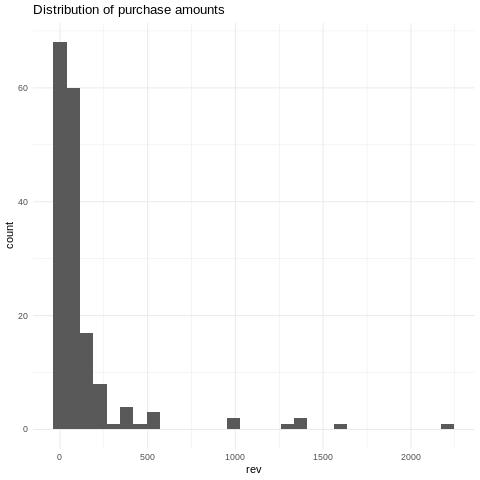

In [33]:
%%R

df %>%
filter(rev > 0) %>%
ggplot(aes(rev)) +
geom_histogram() +
labs(title = "Distribution of purchase amounts") +
theme_minimal()


In [34]:
%%R

df %>%
filter(rev > 0) %>%
select(rev) %>%
summary


      rev         
 Min.   :   1.20  
 1st Qu.:  27.18  
 Median :  58.38  
 Mean   : 141.01  
 3rd Qu.: 112.75  
 Max.   :2211.38  


Long right tail. 

Log normal? Looks like it:

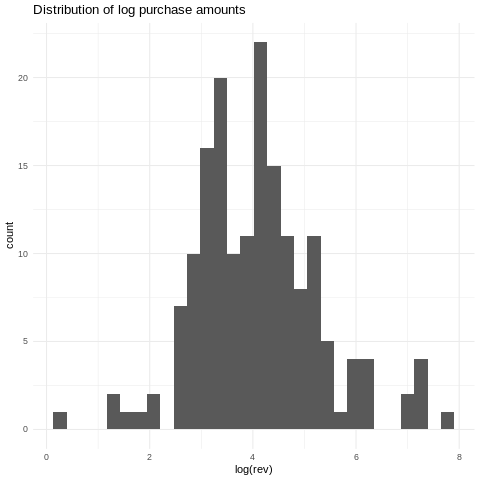

In [35]:
%%R

df %>%
filter(rev > 0) %>%
ggplot(aes(log(rev))) +
geom_histogram() +
labs(title = "Distribution of log purchase amounts") +
theme_minimal()

### Identify and remove invariant columns



In [47]:
%%R 

apply(df, 2, n_distinct)

          fullVisitorId                 visitId                    date 
                  16230                   18381                       8 
                browser         operatingSystem                isMobile 
                     27                      14                       2 
         deviceCategory                    hits               pageviews 
                      3                     150                     110 
             timeOnSite                 bounces            transactions 
                   1430                       2                       3 
     transactionRevenue               newVisits totalTransactionRevenue 
                    154                       2                     165 
        channelGrouping                     rev 
                      7                     154 


In [46]:
%%R 

apply(df, 2, n_distinct) > 1

          fullVisitorId                 visitId                    date 
                   TRUE                    TRUE                    TRUE 
                browser         operatingSystem                isMobile 
                   TRUE                    TRUE                    TRUE 
         deviceCategory                    hits               pageviews 
                   TRUE                    TRUE                    TRUE 
             timeOnSite                 bounces            transactions 
                   TRUE                    TRUE                    TRUE 
     transactionRevenue               newVisits totalTransactionRevenue 
                   TRUE                    TRUE                    TRUE 
        channelGrouping                     rev 
                   TRUE                    TRUE 


No use this boolean to select columns.

In [40]:
%%R

df <- df %>%
select_if(apply(df, 2, n_distinct) >1)

### What is the scope of missing data?

In [45]:
%%R 

summary(df)

 fullVisitorId         visitId              date             browser         
 Length:18704       Min.   :1.470e+09   Length:18704       Length:18704      
 Class :character   1st Qu.:1.470e+09   Class :character   Class :character  
 Mode  :character   Median :1.470e+09   Mode  :character   Mode  :character  
                    Mean   :1.470e+09                                        
                    3rd Qu.:1.471e+09                                        
                    Max.   :1.471e+09                                        
                                                                             
 operatingSystem     isMobile       deviceCategory          hits        
 Length:18704       Mode :logical   Length:18704       Min.   :  1.000  
 Class :character   FALSE:15230     Class :character   1st Qu.:  1.000  
 Mode  :character   TRUE :3474      Mode  :character   Median :  2.000  
                                                       Mean   :  6.137  
           

### Are purchases more likely with mobile?

No, not really:

In [50]:
%%R

df %>% 
group_by(isMobile) %>%
summarize(prop_purchase = sum(rev > 0)/n())

# A tibble: 2 × 2
  isMobile prop_purchase
  <lgl>            <dbl>
1 FALSE          0.0104 
2 TRUE           0.00288


### Are purchases related to the channel?

Referral, though small in absolute terms, accounts for the largest proportion of purchases. Mobile is only involved in organic search and direct.

`summarise()` has grouped output by 'channelGrouping'. You can override using
the `.groups` argument.


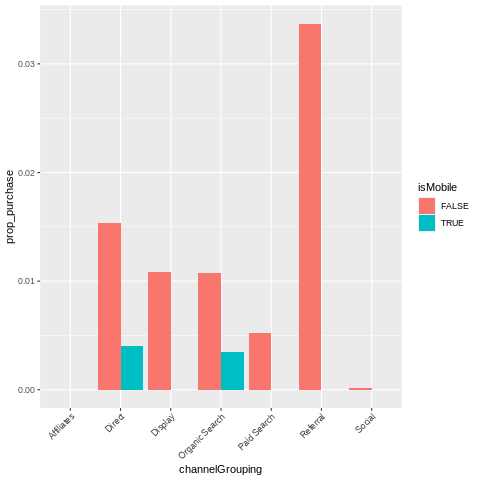

In [56]:
%%R

df %>% 
group_by(channelGrouping, isMobile) %>%
summarize(prop_purchase = sum(rev > 0)/n()) %>%
ggplot(aes(channelGrouping, prop_purchase, fill = isMobile)) +
geom_col(position = "dodge") +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

### What is the distribution of pageviews?

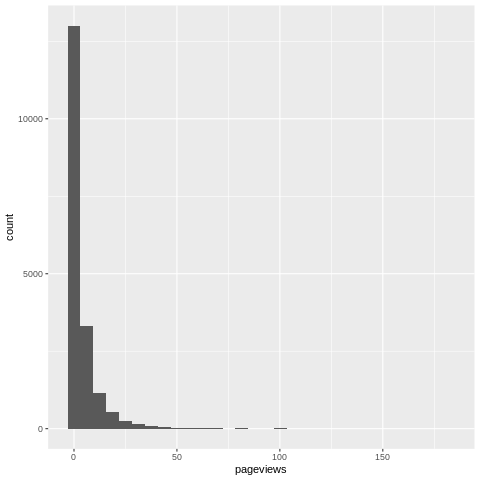

In [57]:
%%R 

df %>%
ggplot(aes(pageviews)) +
geom_histogram()


Related to purchasing? Specifically does the proportion of purchases go up with bucketed page views?

In [74]:
%%R 

df %>%
filter(pageviews > 1) %>%
mutate(pageview_bins = cut(pageviews, 15)) %>%
group_by(pageview_bins) %>%
summarize(prop_purchase = sum(rev > 0)/n(),
          n()) 

# A tibble: 15 × 3
   pageview_bins prop_purchase `n()`
   <fct>                 <dbl> <int>
 1 (1.82,14.1]         0.00362  8291
 2 (14.1,26.1]         0.0503    855
 3 (26.1,38.2]         0.139     267
 4 (38.2,50.3]         0.209     115
 5 (50.3,62.3]         0.291      55
 6 (62.3,74.4]         0.321      28
 7 (74.4,86.5]         0.308      13
 8 (86.5,98.5]         0.143       7
 9 (98.5,111]          0.182      11
10 (111,123]           0.4         5
11 (123,135]           0.125       8
12 (135,147]           0           1
13 (147,159]           0           1
14 (159,171]           0           2
15 (171,183]           0           2
